In [1]:
import requests
from bs4 import BeautifulSoup
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import time
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

***Парсинг данних з сайту auto.ria.com***

In [1117]:
HEADERS = {
            'User-Agent': 'Mozilla/5.0 (Windows NT 6.1; WOW64; rv:49.0) Gecko/20100101 Firefox/49.0',
            'Accept': 'text/html,application/xhtml+xml,application/xml;q=0.9,*/*;q=0.8',
            'Accept-Language': 'en-US,en;q=0.5',
            'Accept-Encoding': 'gzip, deflate',
            'DNT': '1',
            'Connection': 'keep-alive',
            'Upgrade-Insecure-Requests': '1'
        }


In [1118]:
SITE = 'https://auto.ria.com/uk/legkovie/?page=1'

In [1119]:
r = requests.get(SITE, headers = HEADERS)
soup = BeautifulSoup(r.text, 'html')

In [1120]:
def get_pages_number():        # Get number of pages on site
    for el in soup.find_all('span', class_="page-item dhide text-c"):
        pages_number = int(el.text.split('/ ')[1].replace(" ", ""))
    return pages_number
print(get_pages_number())

16666


In [1121]:
def main_parser():
    cars = []
    for page in range (1, get_pages_number()+1):
        site_page = f'https://auto.ria.com/uk/legkovie/?page={page}'
        print(site_page)
        try:
            car_r = requests.get(site_page, headers = HEADERS)
            car_soup = BeautifulSoup(car_r.text, 'html')
        except requests.exceptions.RequestException as e:
            raise SystemExit(e)
            
        for el in car_soup.find_all('section', class_="ticket-item"):
            car_items = []
            for name in el.find_all('div', class_="hide"):
                try:
                    #print("Mark: ", name['data-mark-name'].strip())
                    car_items.append(name['data-mark-name'].strip())
                    #print("Model: ", name['data-model-name'].strip())
                    car_items.append(name['data-model-name'].strip())
                    #print("Year: ", name['data-year'].strip())
                    car_items.append(name['data-year'].strip())
                except:
                    continue
            for price in el.find_all('div', class_='price-ticket'):
                try:
                    #print("Price: ", price['data-main-price'].strip())
                    car_items.append(price['data-main-price'].strip())
                except:
                    continue
            for mileage in el.find_all('li', class_='item-char'):
                try:
                    #print("Char: ", mileage.text.strip())
                    car_items.append(mileage.text.strip())
                except:
                    continue
            was_ = False;
            for state_red in el.find_all('span', class_='state _red'):
                if state_red.text.strip() == "Був в ДТП":
                    was_ = True
                else:
                    continue
            #print("state_red: ", was_)
            car_items.append(was_)
            cars.append(car_items)
            arr = np.array(cars)
            df = pd.DataFrame(arr)
            time.sleep(0)
    df.to_csv("cars_list.csv")

    return df

In [1122]:
#cars_df = main_parser()

### Аналіз автомобільного ринку та передбачення ціни на авто

In [2]:
df = pd.read_csv('cars_6.csv')

In [3]:
df

,Unnamed: 0,0,1,2,3,4,5,6,7,8
0,0,Mercedes-Benz,E 280,2007,8999,160 тис. км,Бориспіль ( від ),"Газ / Бензин, 3 л.",Автомат,False
1,1,Suzuki,SX4,2008,8200,60 тис. км,Київ ( від ),"Бензин, 1.6 л.",Автомат,False
2,2,Toyota,Camry,2018,31900,67 тис. км,Одеса ( від ),"Бензин, 2.5 л.",Автомат,False
3,3,Skoda,Superb,2017,24994,81 тис. км,Тячів ( від ),"Дизель, 2 л.",Робот,False
4,4,Volkswagen,Golf V,2006,7399,143 тис. км,Дрогобич ( від ),"Бензин, 1.6 л.",Ручна / Механіка,False
...,...,...,...,...,...,...,...,...,...,...
27557,27557,Daewoo,Sens,2003,65000,203 тис. км,Лозова ( від ),"Газ / Бензин, 1.3 л.",Ручна / Механіка,False
27558,27558,Volkswagen,Touran,2008,9000,192 тис. км,Козятин ( від ),"Бензин, 1.4 л.",Ручна / Механіка,False
27559,27559,Nissan,370Z,2015,18900,110 тис. км,Івано-Франківськ ( від ),"Бензин, 3.7 л.",Автомат,True
27560,27560,Skoda,Octavia A5,2010,8400,160 тис. км,Миколаїв ( від ),"Дизель, 1.6 л.",Ручна / Механіка,False


In [4]:
def milage_convertor(x):    # Converts milage from alphabetic values to numeric
    if " тис. км" in x:
        x = int(x.replace(' тис. км',"000"))
    else:
        x = 0
    return x

In [5]:
Milage = [milage_convertor(x) for x in (df['4'])]

In [6]:
df['Milage'] = Milage

In [7]:
def eng_type(x):    # encoding of fuel type needed for engine
    if x == "Газ,":
        x = 0
    elif x == "Бензин,":
        x = 1
    elif x == "Дизель,":
        x = 2
    elif x == "Гибрид,":
        x = 3
    else:
        x = 4
    return x

In [8]:
def change_fuel(i):    # uses for filtering specific engine types with "Газ" word included

    if "Газ" in i:
        i = i.split()
        if len(i)>2:
            new = ['Газ', i[-2], i[-1]]
            i = " ".join(new)
        else:
            return i
    else:
        return i
    return i

In [9]:
df['6'] = df['6'].apply(lambda x: change_fuel(x))

In [10]:
df[['fuel_type','Volume','units']] = df['6'].str.split(" ", expand=True,)

In [11]:
Fuel = [eng_type(x) for x in (df['fuel_type'])]
df['Fuel'] = Fuel

In [12]:
df = df.loc[df['units'].notnull()]
df = df.loc[(df['Volume'] != '/')]
df["Volume"] = pd.to_numeric(df["Volume"])
df = df.loc[df['Volume'] < 10]

In [13]:
def transmission(x):   # Transmission encoding
    if "Авто" in x:
        x = 0
    elif "Робот" in x:
        x = 1
    elif "Ручна" in x:
        x = 2
    elif "Мех" in x:
        x = 2
    elif "атор" in x:
        x = 3
    elif "трон" in x:
        x = 4
    else:
        x = 5
    return x

In [14]:
df.drop(df.index[(df['7'] == 'Не вказано') & (df['Fuel'] != 4)], inplace = True)

In [15]:
Transmission = [transmission(x) for x in (df['7'])]
df['Transmission'] = Transmission

In [16]:
df["8"] = df["8"].astype(int)

In [17]:
df.rename(columns = {'0': 'Manufacturer', '1': 'Model', '2': 'Year', '3': 'Price', '8': 'Accident'}, inplace = True)

In [18]:
df_tidy = df[['Manufacturer','Model','Year', 'Milage', 'Fuel', 'Volume', 'Transmission', 'Accident', 'Price' ]]
df_tidy = df_tidy.loc[df_tidy['Year'] <= 2021]
df_tidy = df_tidy.loc[df_tidy['Price']<150000]

In [19]:
df_tidy    # Cleared and converted dataset

,Manufacturer,Model,Year,Milage,Fuel,Volume,Transmission,Accident,Price
0,Mercedes-Benz,E 280,2007,160000,4,3.0,0,0,8999
1,Suzuki,SX4,2008,60000,1,1.6,0,0,8200
2,Toyota,Camry,2018,67000,1,2.5,0,0,31900
3,Skoda,Superb,2017,81000,2,2.0,1,0,24994
4,Volkswagen,Golf V,2006,143000,1,1.6,2,0,7399
...,...,...,...,...,...,...,...,...,...
27557,Daewoo,Sens,2003,203000,4,1.3,2,0,65000
27558,Volkswagen,Touran,2008,192000,1,1.4,2,0,9000
27559,Nissan,370Z,2015,110000,1,3.7,0,1,18900
27560,Skoda,Octavia A5,2010,160000,2,1.6,2,0,8400


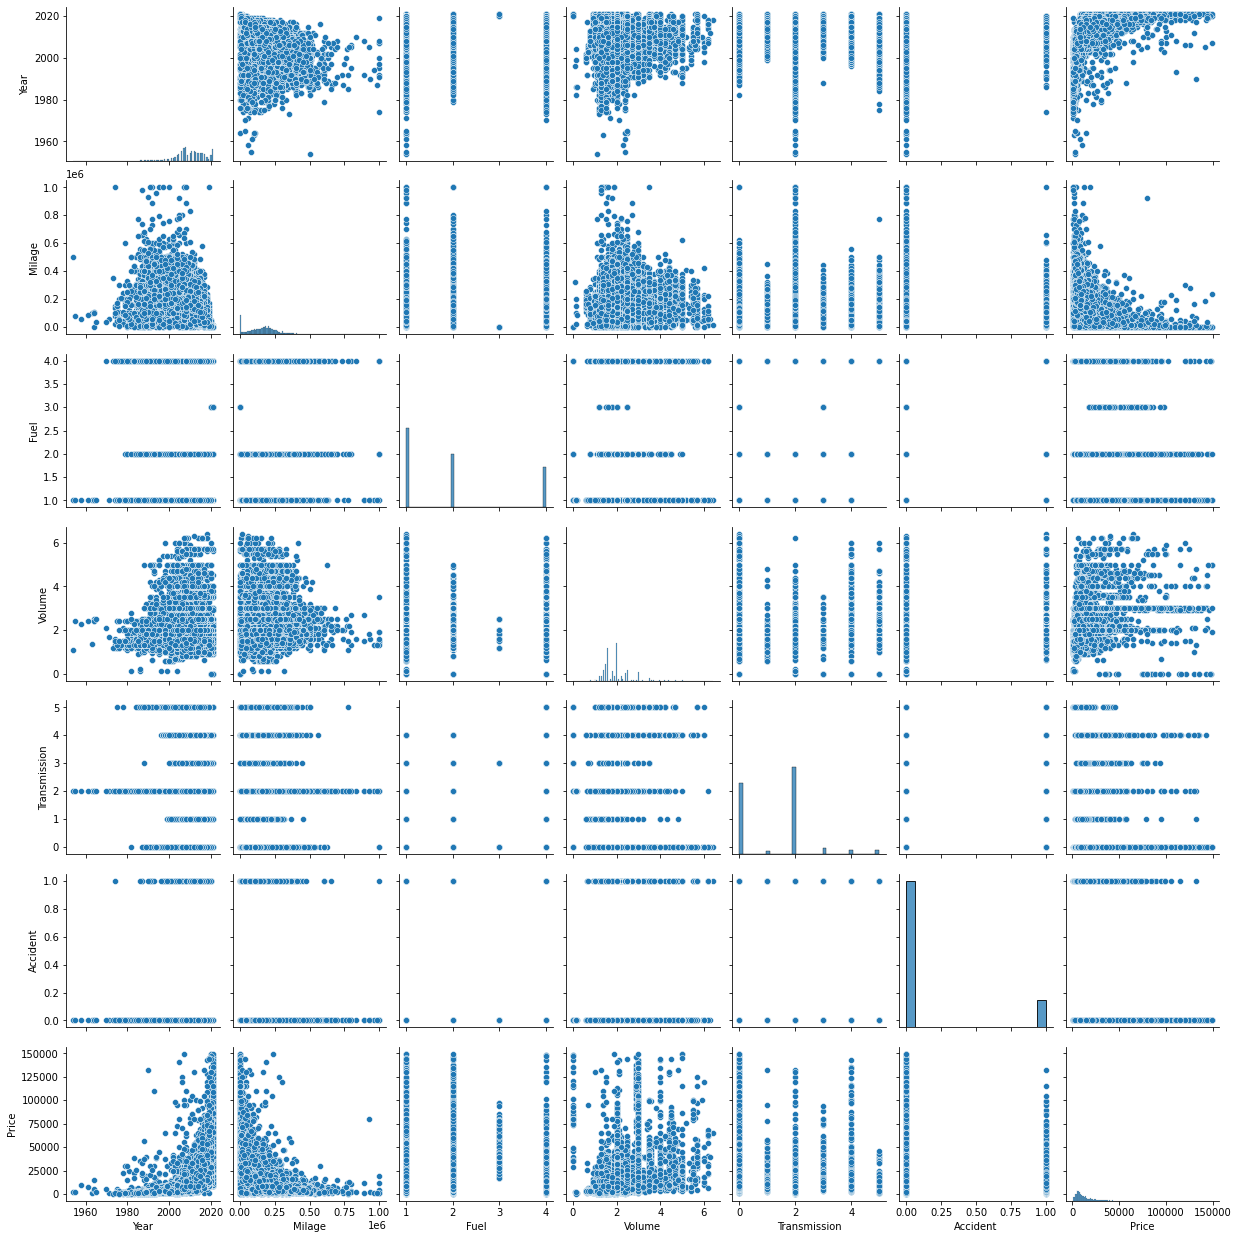

In [20]:
sns.pairplot(df_tidy)

In [21]:
cat_cols= [col for col in df_tidy.columns if df_tidy[col].dtype=='object']
num_cols= [col for col in df_tidy.columns if df_tidy[col].dtype!='object']
num_cols.pop(-1)

'Price'

In [22]:
cat_cols

['Manufacturer', 'Model']

In [23]:
num_cols

['Year', 'Milage', 'Fuel', 'Volume', 'Transmission', 'Accident']

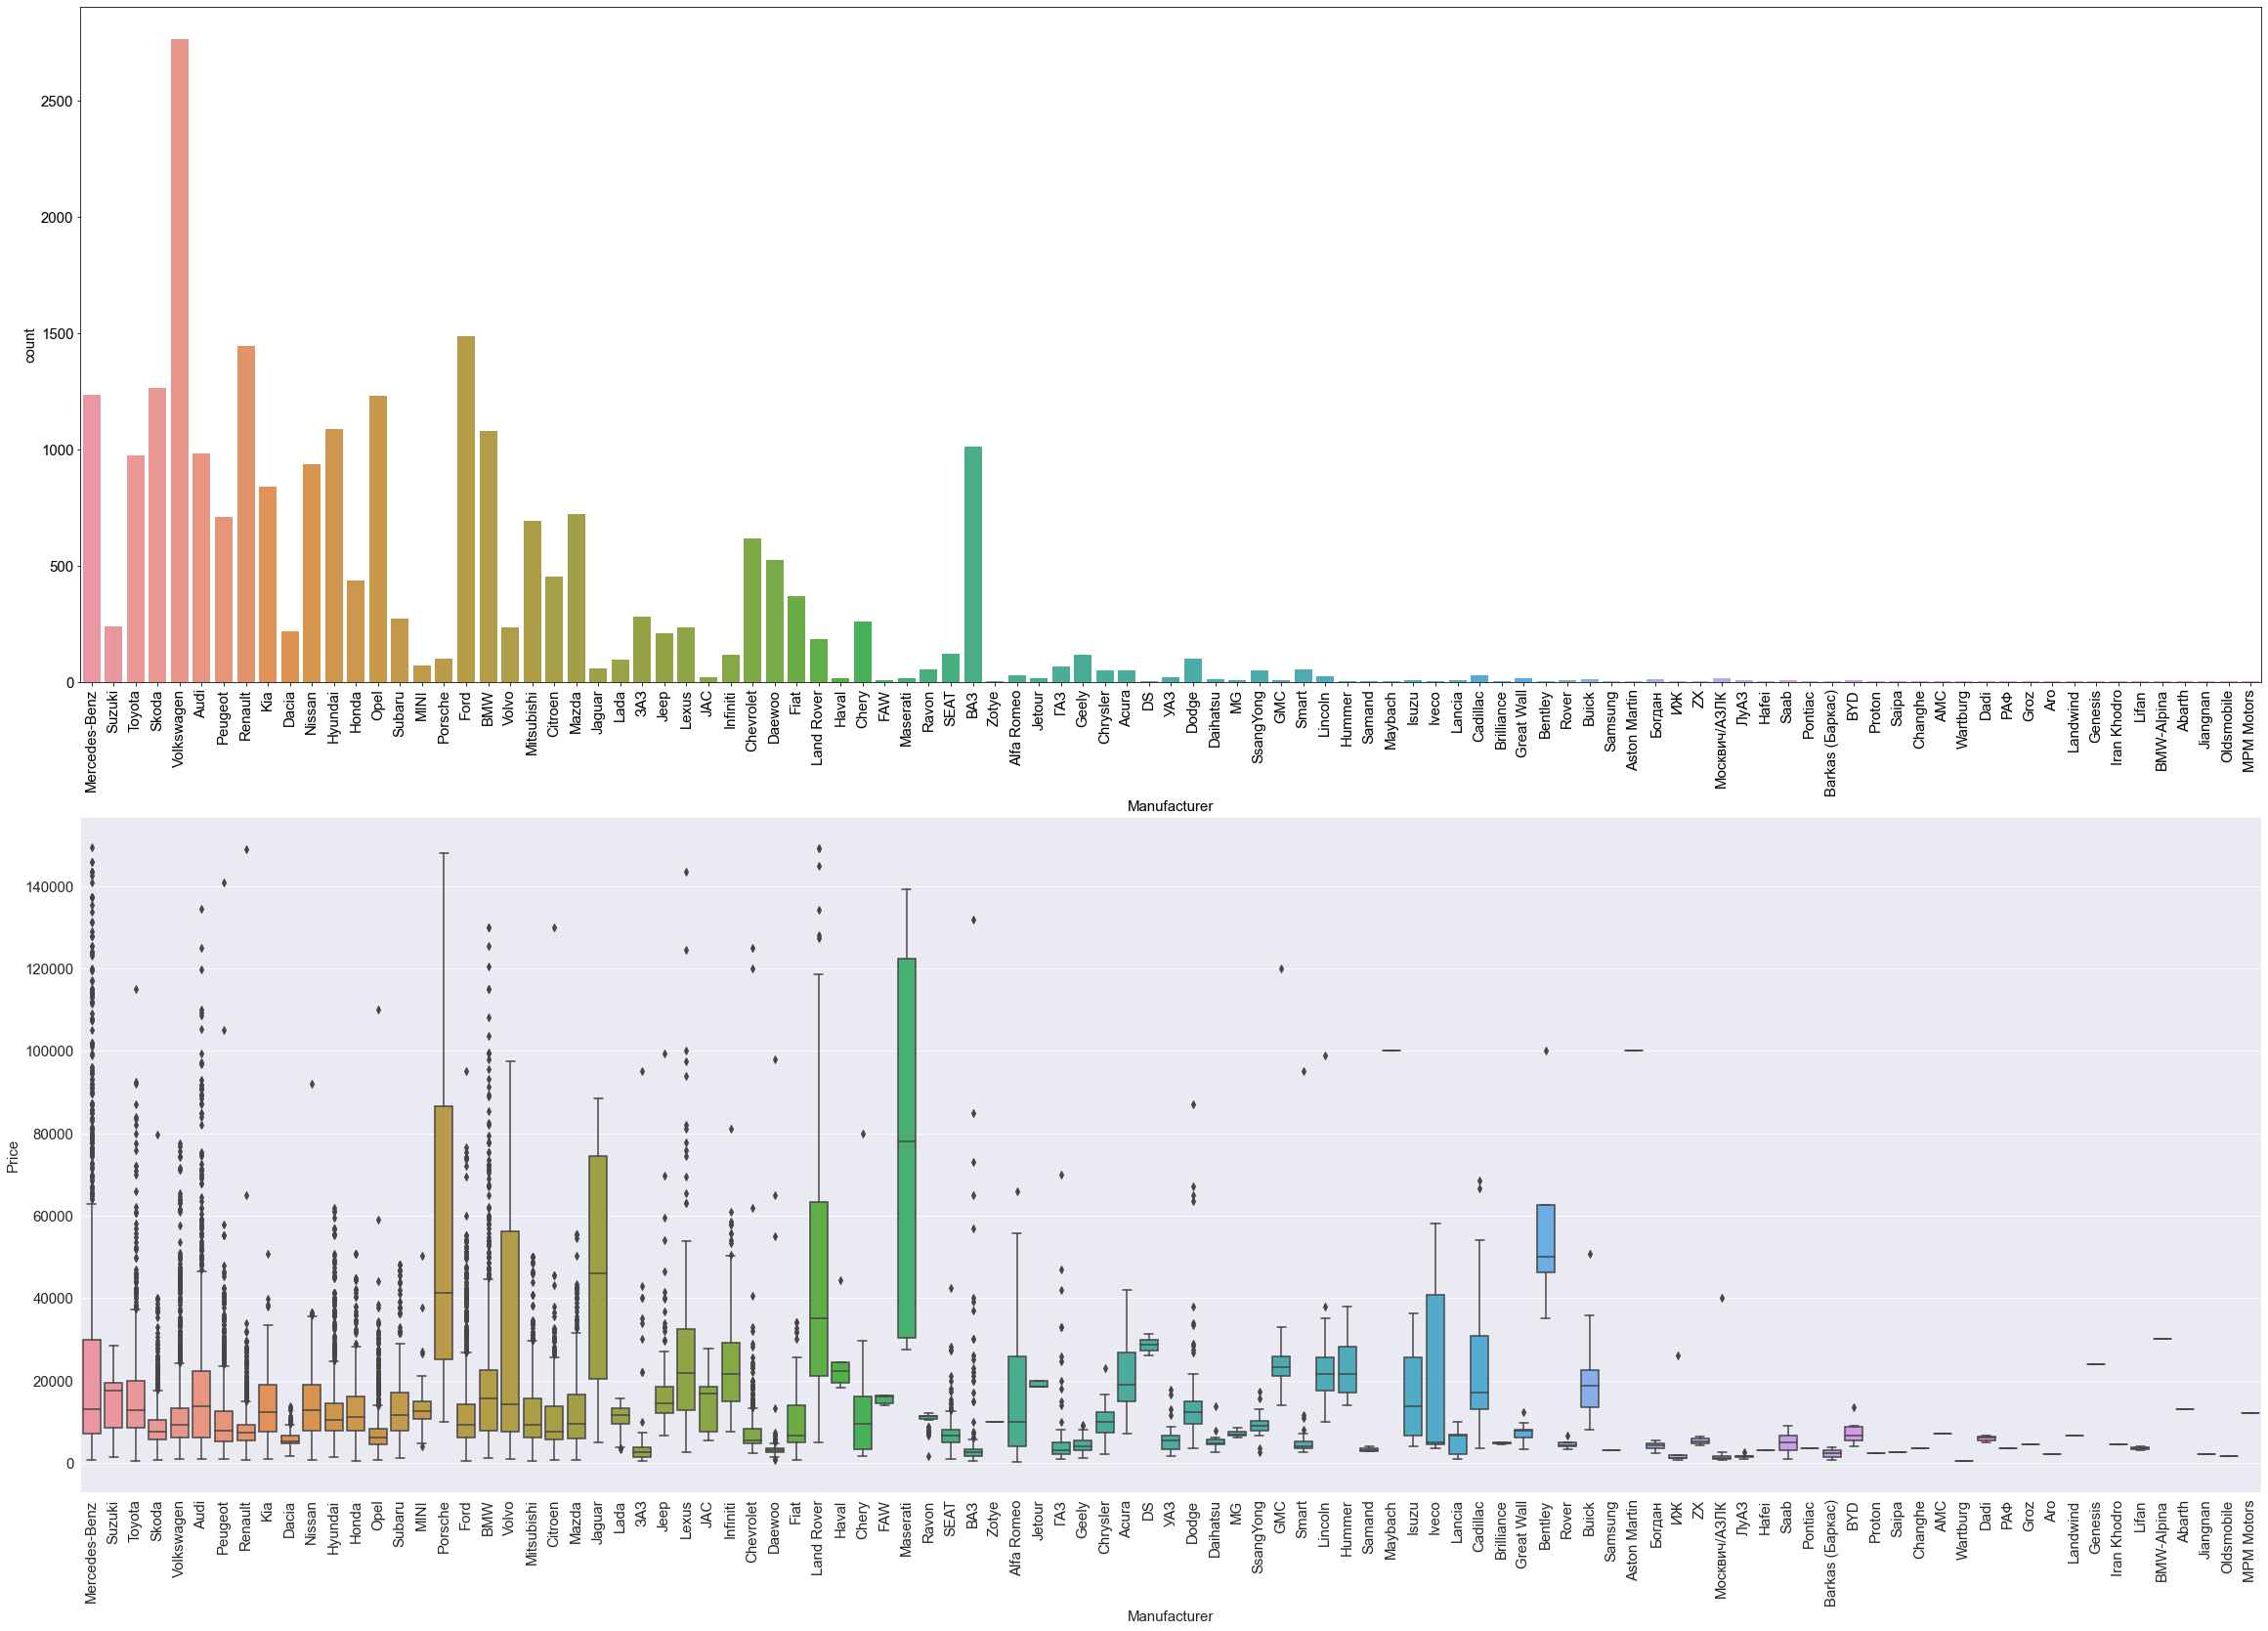

In [24]:
plt.figure(figsize=(40,150))

plt.subplot(10,1,1)
sns.countplot(df_tidy['Manufacturer'])
plt.xticks(rotation=90, fontsize=15)
plt.yticks(fontsize=15)
plt.xlabel('Manufacturer', fontsize=15)
plt.ylabel('count',fontsize=15)
sns.set_style('darkgrid')


plt.subplot(10,1,2)
sns.boxplot(x=df_tidy['Manufacturer'], y=df_tidy['Price'])
plt.xticks(rotation=90, fontsize=15)
plt.yticks(fontsize=15)
plt.xlabel('Manufacturer', fontsize=15)
plt.ylabel('Price',fontsize=15)


plt.show()

1. На графіку зображено кількість оголошень із автомобілями певної марки
2. Розподіл цін на ці автомобілі відповідно

***Найпопулярніші марки авто***

In [25]:
df_tidy["Manufacturer"].value_counts()

Volkswagen       2765
Ford             1487
Renault          1445
Skoda            1262
Mercedes-Benz    1232
                 ... 
Hafei               1
Maybach             1
MPM Motors          1
Groz                1
Pontiac             1
Name: Manufacturer, Length: 99, dtype: int64

***Найпопулярніші моделі авто***

In [26]:
df_tidy["Model"].value_counts()   # The most popular models on the market

Megane             463
Focus              415
Lanos              339
Octavia A5         337
Passat B7          310
                  ... 
Ioniq                1
Sedona               1
S 55 AMG             1
GL 500               1
Tourneo Courier      1
Name: Model, Length: 1365, dtype: int64

***На графіку вище було помітно, що розподіл цін на автомобілі незавжди однорідний. 
Особливо це помінтно на прикладі марки Mercedes-Benz.
Така ситуація обумовлена тим, що більшіть автомобілів на сайті старі, а нові моделі значно вирізняються високою ціною.
Нижче на прикладі Mercedes-Benz показано розподіл по рокам***

In [27]:
df_tidy.loc[df_tidy['Manufacturer'] == 'Mercedes-Benz']['Year'].value_counts()

2021    101
2008     74
2007     64
2010     60
2006     59
2011     57
2014     55
2005     54
2015     52
2001     46
2013     45
2016     44
2017     44
2012     42
2004     40
2020     39
2003     39
2002     39
2000     37
1999     36
2018     28
2009     24
1997     20
1998     18
1995     14
2019     14
1994     14
1996     13
1993     12
1992     11
1989      8
1987      6
1991      4
1986      4
1988      3
1990      3
1983      2
1982      2
1985      2
1980      2
1979      1
Name: Year, dtype: int64

Авто преміум класу, котрі продаються

In [28]:
df_tidy.loc[df_tidy['Price']>100000].head()

,Manufacturer,Model,Year,Milage,Fuel,Volume,Transmission,Accident,Price
42,Mercedes-Benz,GLE 400,2021,0,2,2.9,0,0,116841
76,Mercedes-Benz,GLE 400,2021,0,2,2.9,0,0,127777
80,BMW,X6,2020,25000,1,3.0,0,0,108200
86,Porsche,Taycan,2021,0,4,0.0,0,0,147780
134,Mercedes-Benz,GLS 350,2021,2000,2,2.9,0,0,115000


Авто за ціною велосипеду/смартфону :D

In [29]:
df_tidy.loc[df_tidy['Price']<700]    

,Manufacturer,Model,Year,Milage,Fuel,Volume,Transmission,Accident,Price
10738,ЗАЗ,1102 Таврія,1993,300000,1,1.20,2,0,450
10782,ВАЗ,2101,1975,42000,1,1.30,2,0,650
10819,ЗАЗ,1102 Таврія,1991,86000,4,1.10,2,0,550
11474,ЗАЗ,1103 Славута,2005,98000,4,1.20,2,1,500
11760,Ford,Sierra,1989,200000,1,2.00,2,0,500
11959,Mercedes-Benz,E 240,1980,250000,2,2.40,2,0,550
12041,ЗАЗ,1102 Таврія,1992,777000,1,1.10,2,0,400
12268,ВАЗ,2105,1987,70000,1,1.30,2,0,680
12346,Alfa Romeo,33,1985,156000,4,1.40,2,0,300
12500,ВАЗ,2101,1985,111000,1,1.20,2,0,650


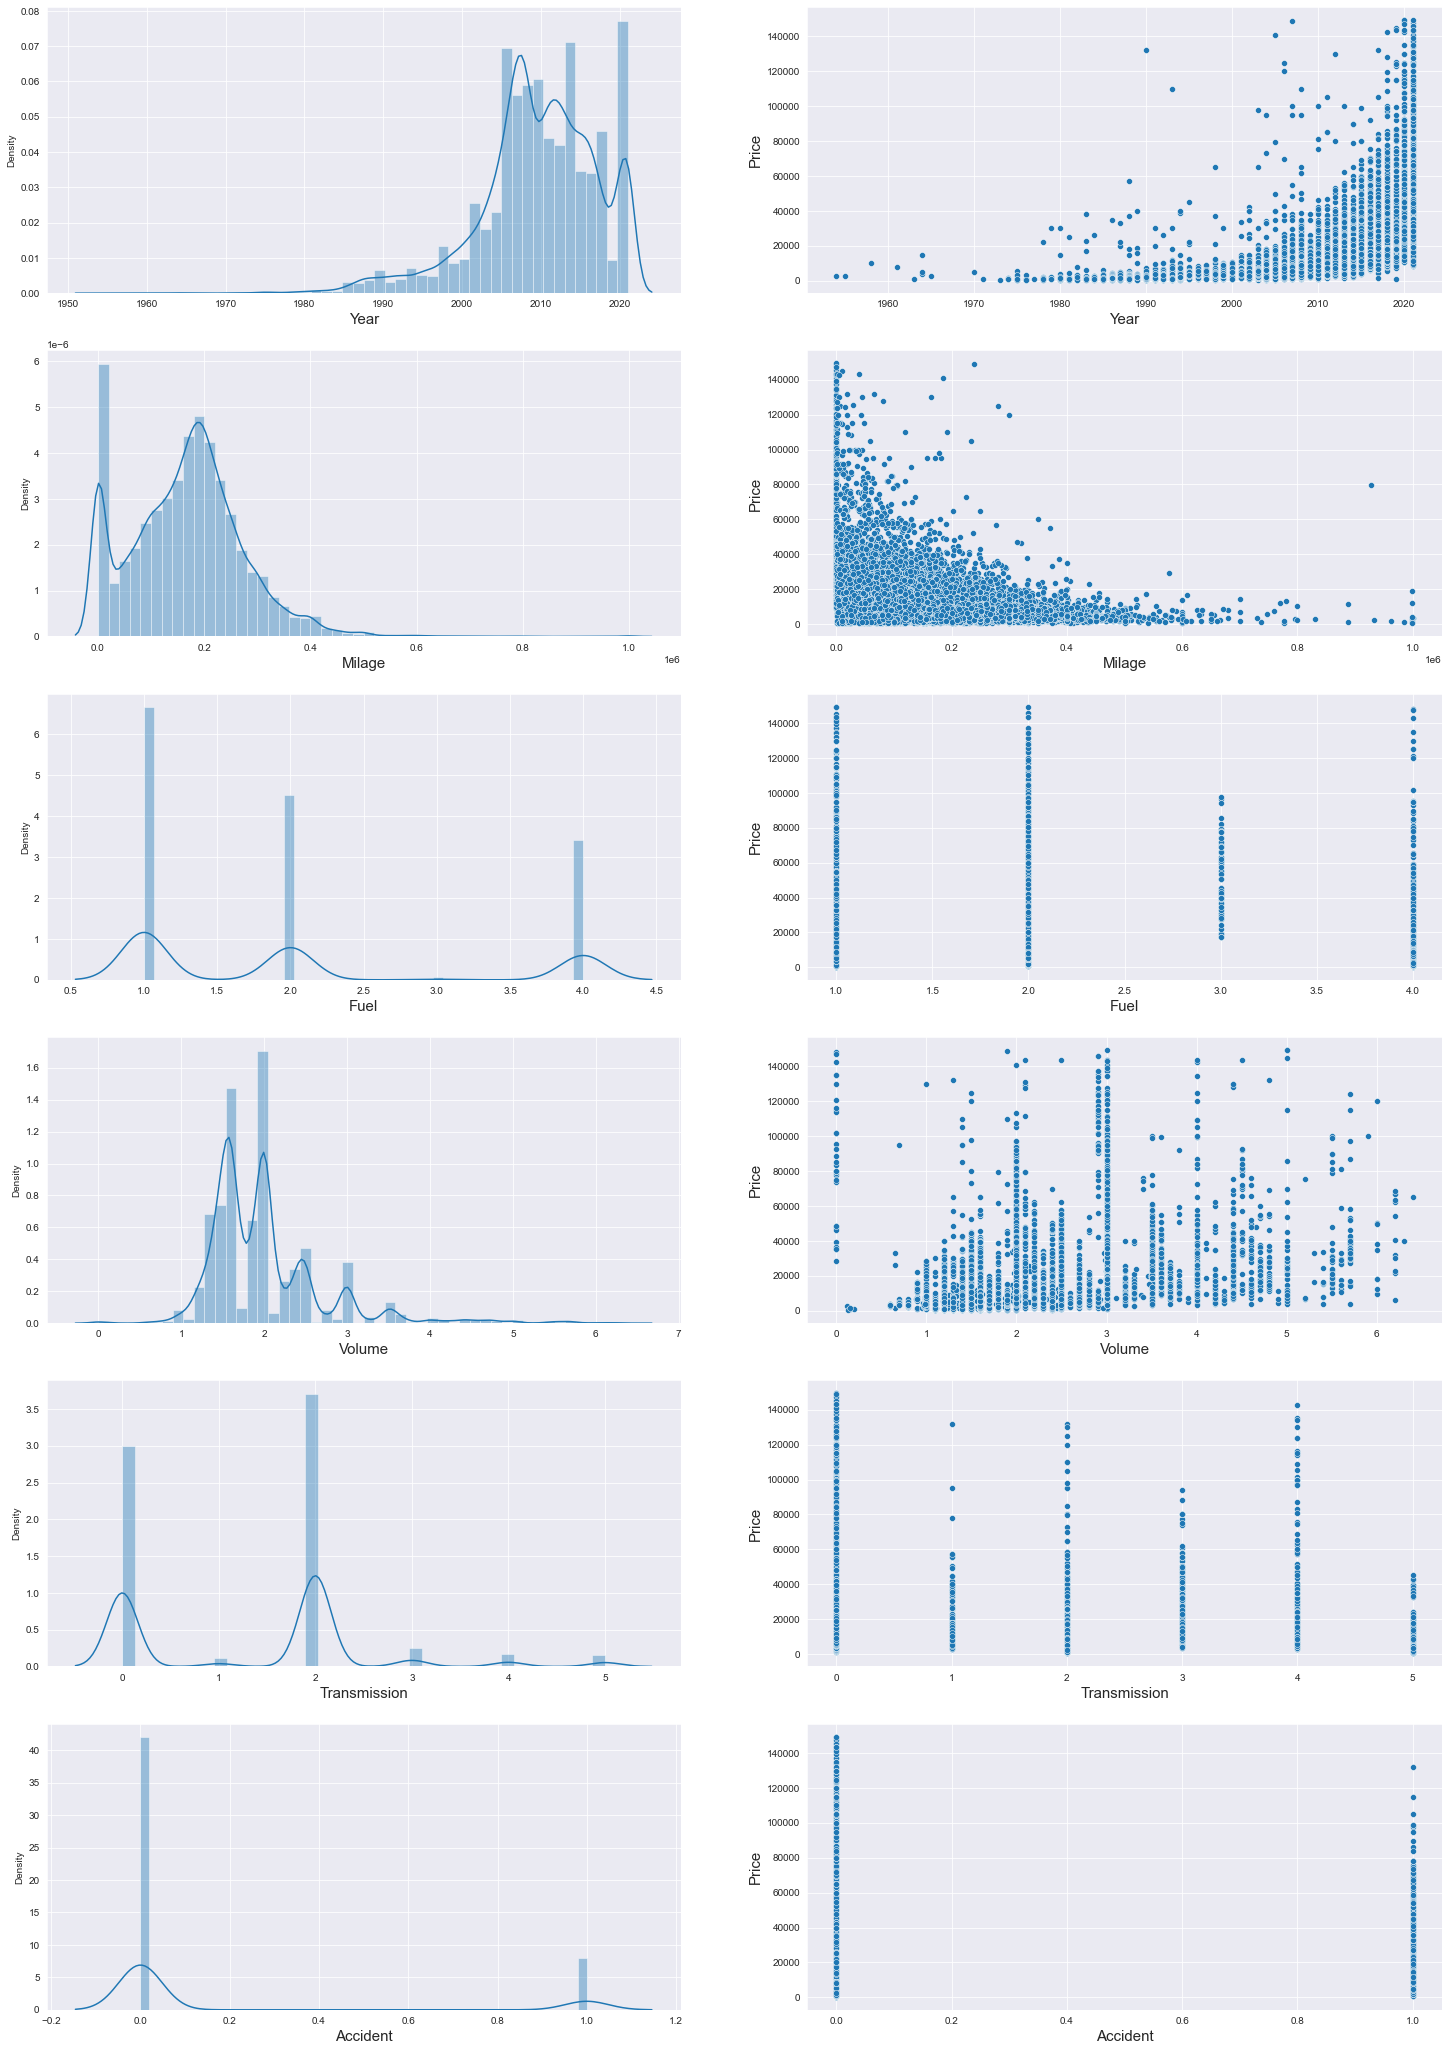

In [30]:
i=1
plt.figure(figsize=(25,100))
for col in num_cols:
    plt.subplot(16,2,i)
    sns.distplot(df_tidy[col])
    plt.xlabel(col,fontsize=15)
    plt.xticks(fontsize=10)
    i+=1
    
    plt.subplot(16,2,i)
    sns.scatterplot(x=df[col], y=df_tidy['Price'])
    plt.xlabel(col,fontsize=15)
    plt.xticks(fontsize=10)
    plt.ylabel('Price', fontsize=15)
    plt.yticks(fontsize=10)
    i+=1
    

***На даних графіках зображено розподіл густини (частоти) параметрів автомобіля, а також їх вплив на ціну (зліва та справа відповідно).
Можна побачити, що рік випуску та пробіг мають сильний зв'язок із ціною. Скоріше за все вони будуть ключовими факторами, що впливатимуть на формування ціни***

Найбільш вживані об'єми двигунів

In [31]:
df_tidy['Volume'].value_counts() 

2.00    5291
1.60    4599
1.50    2323
1.40    1522
2.50    1458
        ... 
2.38       1
0.13       1
2.47       1
2.35       1
1.29       1
Name: Volume, Length: 121, dtype: int64

***Даний графік є термокартою і показує кореляцію різних параметрів між собою.
Як можемо бачити рік має досить високу пряму залежність на ціну, а пробіг високу зворотну, що також можна було бачити на графіках вище.
Також є велика зворотна залежність між роком та пробігом, що є логічним.***

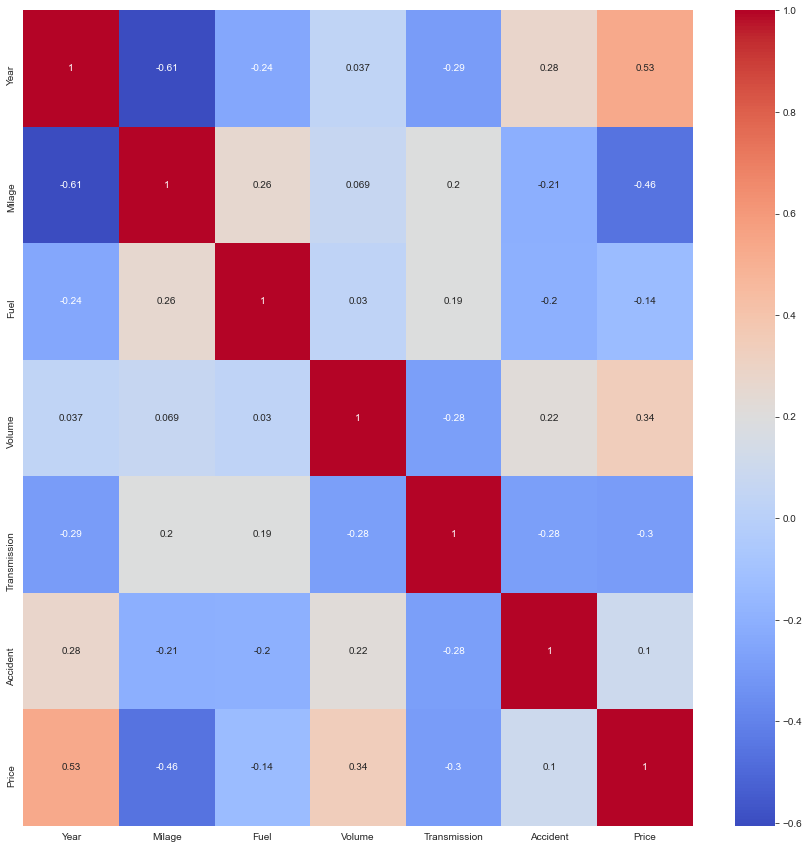

In [32]:
plt.figure(figsize=(15,15))
sns.heatmap(df_tidy.corr(), annot=True, cmap='coolwarm')
plt.show()

***Навчання моделей***

In [33]:
df_learning = df_tidy.copy()

In [34]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()

df_learning[cat_cols]= df_learning[cat_cols].apply(lambda x: le.fit_transform(x))

In [35]:
df_learning.head()

,Manufacturer,Model,Year,Milage,Fuel,Volume,Transmission,Accident,Price
0,62,475,2007,160000,4,3.0,0,0,8999
1,83,1066,2008,60000,1,1.6,0,0,8200
2,84,375,2018,67000,1,2.5,0,0,31900
3,79,1162,2017,81000,2,2.0,1,0,24994
4,85,643,2006,143000,1,1.6,2,0,7399


In [36]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score

In [37]:
X = df_learning.drop('Price', axis=1)
y = df_learning['Price']

X_train,X_test,y_train,y_test= train_test_split(X,y,test_size=0.2, random_state= 42)

In [38]:
lr = LinearRegression()
lr.fit(X_train,y_train)
y_pred = lr.predict(X_test)

rmse = (mean_squared_error(y_test,y_pred))**(1/2)
r2 = r2_score(y_test,y_pred)

print(rmse)
print(r2)

10381.958523440448
0.4557588559176484


*Як бачимо, звичайна лінійна регресія показала хорошого результату*

In [39]:
dt = DecisionTreeRegressor(criterion='mse', splitter='best', max_depth=100, min_samples_leaf= 5, random_state=42)
dt.fit(X_train,y_train)
y_pred = dt.predict(X_test)

rmse_train = (mean_squared_error(dt.predict(X_train),y_train))**(1/2)
rmse = (mean_squared_error(y_test,y_pred))**(1/2)
r2 = r2_score(y_test,y_pred)
print(rmse_train)
print(rmse)
print(r2)

4151.458602914719
6086.287212674077
0.8129586287663287


In [40]:
rf = RandomForestRegressor(max_depth=10, criterion='mse', min_samples_leaf=2, random_state=42, verbose=1)
rf.fit(X_train,y_train)
y_pred = rf.predict(X_test)
rmse_train = (mean_squared_error(rf.predict(X_train),y_train))**(1/2)
rmse = (mean_squared_error(y_test,y_pred))**(1/2)
r2 = r2_score(y_test,y_pred)
print(rmse_train)
print(rmse)
print(r2)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    3.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


4066.415596614762
5387.794690090336
0.8534266993474241


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.1s finished


In [41]:
xgb = XGBRegressor()
xgb.fit(X_train, y_train)
y_pred = xgb.predict(X_test)
rmse_train = (mean_squared_error(xgb.predict(X_train),y_train))**(1/2)
rmse = (mean_squared_error(y_test,y_pred))**(1/2)
r2 = r2_score(y_test,y_pred)
print(rmse_train)
print(rmse)
print(r2)

2695.8116680529406
5033.321041012183
0.8720789381439629


*Всі наступні моделі справились майже однаково та мають коефіцієнт детермінації вище 80%*

In [42]:
def get_data():
    Manufacturer = input("Марка (приклад: Suzuki): " )
    Model = input("Модель (приклад: SX4): ")
    Year = input("Рік випуску (приклад: 2012): ")
    Milage = input("Пробіг (приклад: 160000): ")
    Fuel = input("Тип пального (приклад: газ - 0, бензин - 1, дизель - 2, гібрид - 3, електро - 4): ")
    Volume = input("Об'єм двигуна в літрах (приклад: 2): ")
    Transmission = input("Тип трасмісії(Автомат - 0, Робот - 1, Ручна - 2, Варіатор - 3, Типтронік - 4, Немає - 5): ")
    Accident = input("ДТП (Ні - 0/Так - 1): ")
    car_input = [Manufacturer,Model,Year, Milage, Fuel, Volume, Transmission, Accident]
    np.array(car_input)
    
    index = df_tidy.index
    Manufacturers_condition = df_tidy["Manufacturer"] == Manufacturer
    Manufacturers_indices = index[Manufacturers_condition]
    Manufacturers_indices_list = Manufacturers_indices.tolist()
    Models_condition = df_tidy["Model"] == Model
    Models_indices = index[Models_condition]
    Models_indices_list = Models_indices.tolist()
    
    Manufacturer_index = df_learning.iloc[Manufacturers_indices_list[0]][0]
    Model_index = df_learning.iloc[Models_indices_list[0]][1]
    
    car_input = [Manufacturer_index,Model_index,Year, Milage, Fuel, Volume, Transmission, Accident]
    car = [car_input]
    
    df_n = pd.DataFrame(data = car, columns = ['Manufacturer','Model','Year', 'Milage', 'Fuel', 'Volume', 'Transmission', 'Accident'])
    
    return df_n

In [43]:
def prediction(userdf):
    y_pred = lr.predict(userdf)
    print("LinearRegression: ", round(y_pred[0],0))
    y_pred = dt.predict(userdf)
    print("DecisionTreeRegressor: ", round(y_pred[0],0))
    y_pred = rf.predict(userdf)
    print("RandomForestRegressor: ", round(y_pred[0],0))
    y_pred = xgb.predict(userdf)
    print("XGBRegressor: ", round(y_pred[0],0))

***Можемо скористатись вище згаданими моделями та оцінити результат на реальній ціні***

In [46]:
df_new = get_data()

Марка (приклад: Suzuki): Subaru
Модель (приклад: SX4): Tribeca
Рік випуску (приклад: 2012): 2008
Пробіг (приклад: 160000): 334000
Тип пального (приклад: газ - 0, бензин - 1, дизель - 2, гібрид - 3, електро - 4): 0
Об'єм двигуна в літрах (приклад: 2): 3.6
Тип трасмісії(Автомат - 0, Робот - 1, Ручна - 2, Варіатор - 3, Типтронік - 4, Немає - 5): 4
ДТП (Ні - 0/Так - 1): 0


In [47]:
prediction(df_new)

LinearRegression:  16567.0
DecisionTreeRegressor:  12457.0
RandomForestRegressor:  13098.0
XGBRegressor:  12694.0


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished


***Моделі DecisionTreeRegressor та XGBRegressor показали досить хороші результати на реальних даних.***